In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
collection_n_values = [1,2,4,8,16,32,64,128,256]
collection_sizes = [52342886, 26171443, 13085721, 6542860, 3271430, 1635715, 817857, 408928, 204464]
data_dir_clueweb = path.join("Data", "clueweb")
data_dir_wikt = path.join("Data", "wikt")

## nERR-IA

### Preparing data

In [2]:
#Initialise data dictionary with column names and empty lists
data = {"n" : [], "size" : [], "stemmer" : [], "QID" : [], "nERR" : []}
data_avg = {"n" : [], "size" : [], "stemmer" : [], "nERR" : []}
QID = np.arange(201,301)
for n, size in zip(collection_n_values, collection_sizes):
    #Gather the data from each length file
    values = list()
    values_avg = list()
    queryTotal = 0
    with open(path.join(data_dir_clueweb,f"collectionSize/nERR-{n}"), "r") as f:
        for line in f:
            if line[0].isalpha(): 
                queryTotal = 0
                continue
            queryTotal+=1
            if queryTotal > 100:
                values_avg.append(float(line.strip()))
                continue
            values.append(float(line.strip()))
    i = 0
    for stemmer in labels:
        data["nERR"].extend(values[100*i:100*(i+1)])
        data["size"].extend([size for _ in QID])
        data["n"].extend([n for _ in QID])
        data["stemmer"].extend([stemmer for _ in QID])
        data["QID"].extend(QID)
        i+=1
    data_avg["nERR"].extend(values_avg)
    data_avg["size"].extend([size for _ in labels])
    data_avg["n"].extend([n for _ in labels])
    data_avg["stemmer"].extend(labels)
nERR_size = pd.DataFrame(data)
nERR_size_avg = pd.DataFrame(data_avg)
# display(nERR_size)
# display(nERR_size_avg)

### Average nERR-IA

In [3]:
best_nERR = list()
for size in collection_sizes:
    selected_data = nERR_size_avg[nERR_size_avg["size"] == size]
    best_nERR.append(selected_data["nERR"].max())

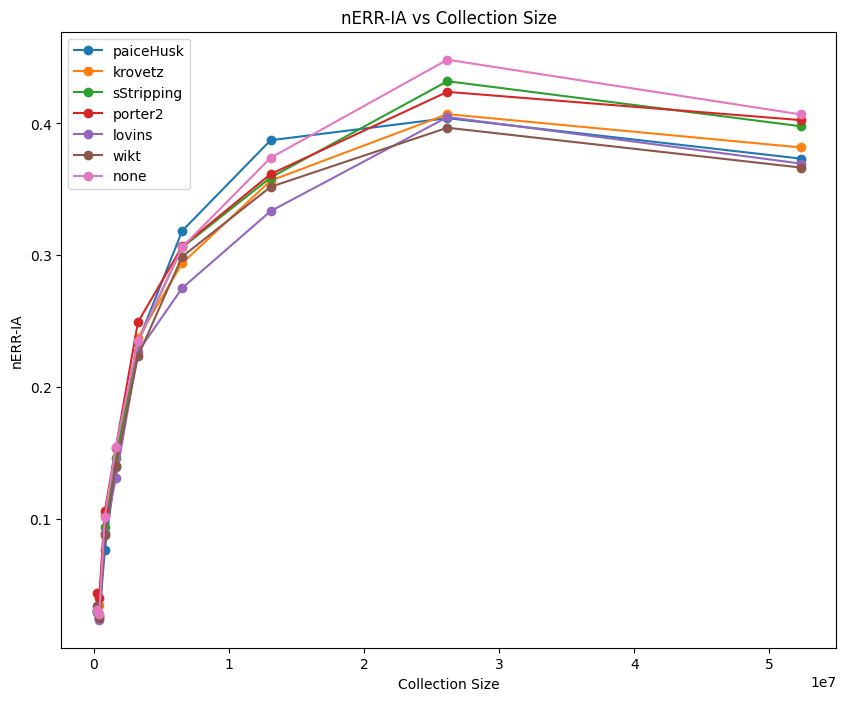

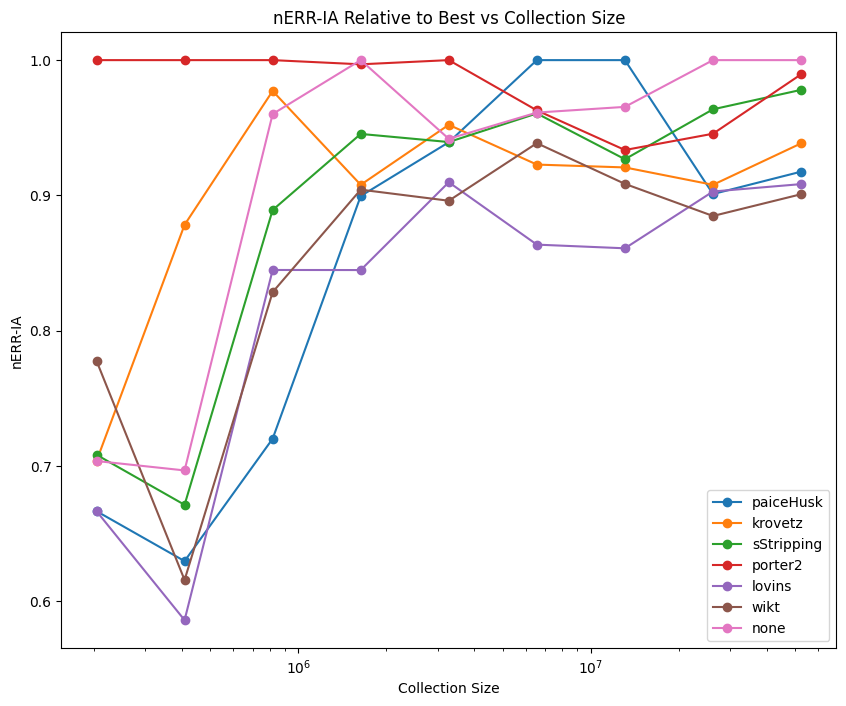

In [4]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nERR_size_avg[nERR_size_avg["stemmer"] == stemmer]
    plt.plot(stemmer_data["size"], stemmer_data["nERR"], "o-", label=stemmer)

plt.title("nERR-IA vs Collection Size")
plt.xlabel("Collection Size")
plt.ylabel("nERR-IA")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nERR_size_avg[nERR_size_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nERR"])/best_nERR
    plt.plot(stemmer_data["size"], stemmer_values, "o-", label=stemmer)
    plt.xscale("log")

plt.title("nERR-IA Relative to Best vs Collection Size")
plt.xlabel("Collection Size")
plt.ylabel("nERR-IA")
plt.legend()

In [ ]:
sns.catplot(data=nERR_size_avg, kind="bar", x="stemmer", y="nERR", col="size", col_wrap=3)
plt.show()

### Results per query

In [ ]:
size = 52342886
nERR = nERR_size[nERR_size["size"] == size]
# for q in QID:
#     q_nERR = nERR[nERR["QID"] == q]
#     # print(f"Query ID: {q}")
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].max()])
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].min()])
#     display(q_nERR[q_nERR["stemmer"] == "none"])
#     display(q_nERR[q_nERR["stemmer"] == "wikt"])
#     print()

display(nERR[nERR["QID"] == 232])
    

### Statistical Significance

In [8]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
porter = list()
none = list()
for size in collection_sizes:
    p = list()
    n = list()
    target_data = nERR_size[nERR_size["size"] == size]
    p = target_data[target_data["stemmer"] == "porter2"].loc[:,"nERR"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nERR"].tolist()
    print(f"Size: {size} {stats.ttest_rel(p,n)}")
    porter.extend(p)
    none.extend(n)
print()
print(f"Overall: {stats.ttest_rel(porter,none)}")

Size: 52342886 TtestResult(statistic=-0.1581571541596552, pvalue=0.8749829661699075, df=49)
Size: 26171443 TtestResult(statistic=-0.9087276528626319, pvalue=0.36794194921222156, df=49)
Size: 13085721 TtestResult(statistic=-0.7023624752404959, pvalue=0.48577644159445876, df=49)
Size: 6542860 TtestResult(statistic=0.04346373344528805, pvalue=0.9655085106833541, df=49)
Size: 3271430 TtestResult(statistic=1.0409229112446732, pvalue=0.30302028469811143, df=49)
Size: 1635715 TtestResult(statistic=-0.03257827982205025, pvalue=0.9741432347842839, df=49)
Size: 817857 TtestResult(statistic=0.3323565959407562, pvalue=0.7410376601476956, df=49)
Size: 408928 TtestResult(statistic=1.376573897005115, pvalue=0.17490191872180627, df=49)
Size: 204464 TtestResult(statistic=0.9999999999999999, pvalue=0.32222340595067556, df=49)

Overall: TtestResult(statistic=0.048715197589225774, pvalue=0.961167925946953, df=449)


In [10]:
#t-test between the wikt stemmer (one of the lowest performing) and no stemming
stemmer = list()
none = list()
for size in collection_sizes:
    s = list()
    n = list()
    target_data = nERR_size[nERR_size["size"] == size]
    s = target_data[target_data["stemmer"] == "wikt"].loc[:,"nERR"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nERR"].tolist()
    print(f"Size: {size} {stats.ttest_rel(s,n)}")
    stemmer.extend(s)
    none.extend(n)
print()
print(f"Overall: {stats.ttest_rel(stemmer,none)}")

Size: 52342886 TtestResult(statistic=-1.4690201049804772, pvalue=0.1482186385492425, df=49)
Size: 26171443 TtestResult(statistic=-1.9958333560557207, pvalue=0.05152604765152262, df=49)
Size: 13085721 TtestResult(statistic=-1.0864858103074182, pvalue=0.28258014085384525, df=49)
Size: 6542860 TtestResult(statistic=-0.45916145020138616, pvalue=0.6481487305235993, df=49)
Size: 3271430 TtestResult(statistic=-0.943515103671333, pvalue=0.35004658510123654, df=49)
Size: 1635715 TtestResult(statistic=-1.0506186758727827, pvalue=0.298587825878836, df=49)
Size: 817857 TtestResult(statistic=-1.197185288335295, pvalue=0.23699417189313837, df=49)
Size: 408928 TtestResult(statistic=-0.5043732529289646, pvalue=0.6162597292638603, df=49)
Size: 204464 TtestResult(statistic=1.0000000000000002, pvalue=0.3222234059506757, df=49)

Overall: TtestResult(statistic=-3.154780490536547, pvalue=0.0017140844743041945, df=449)


### Linguistic Accuracy

In [6]:
nERR_fmeasure = nERR_size_avg[nERR_size_avg["stemmer"] != "none"]
nERR_fmeasure = nERR_fmeasure[nERR_fmeasure["stemmer"] != "wikt"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
fmeasures = list()
for size in collection_sizes:
    fmeasures.extend(averages)
nERR_fmeasure = nERR_fmeasure.assign(fmeasure=fmeasures)

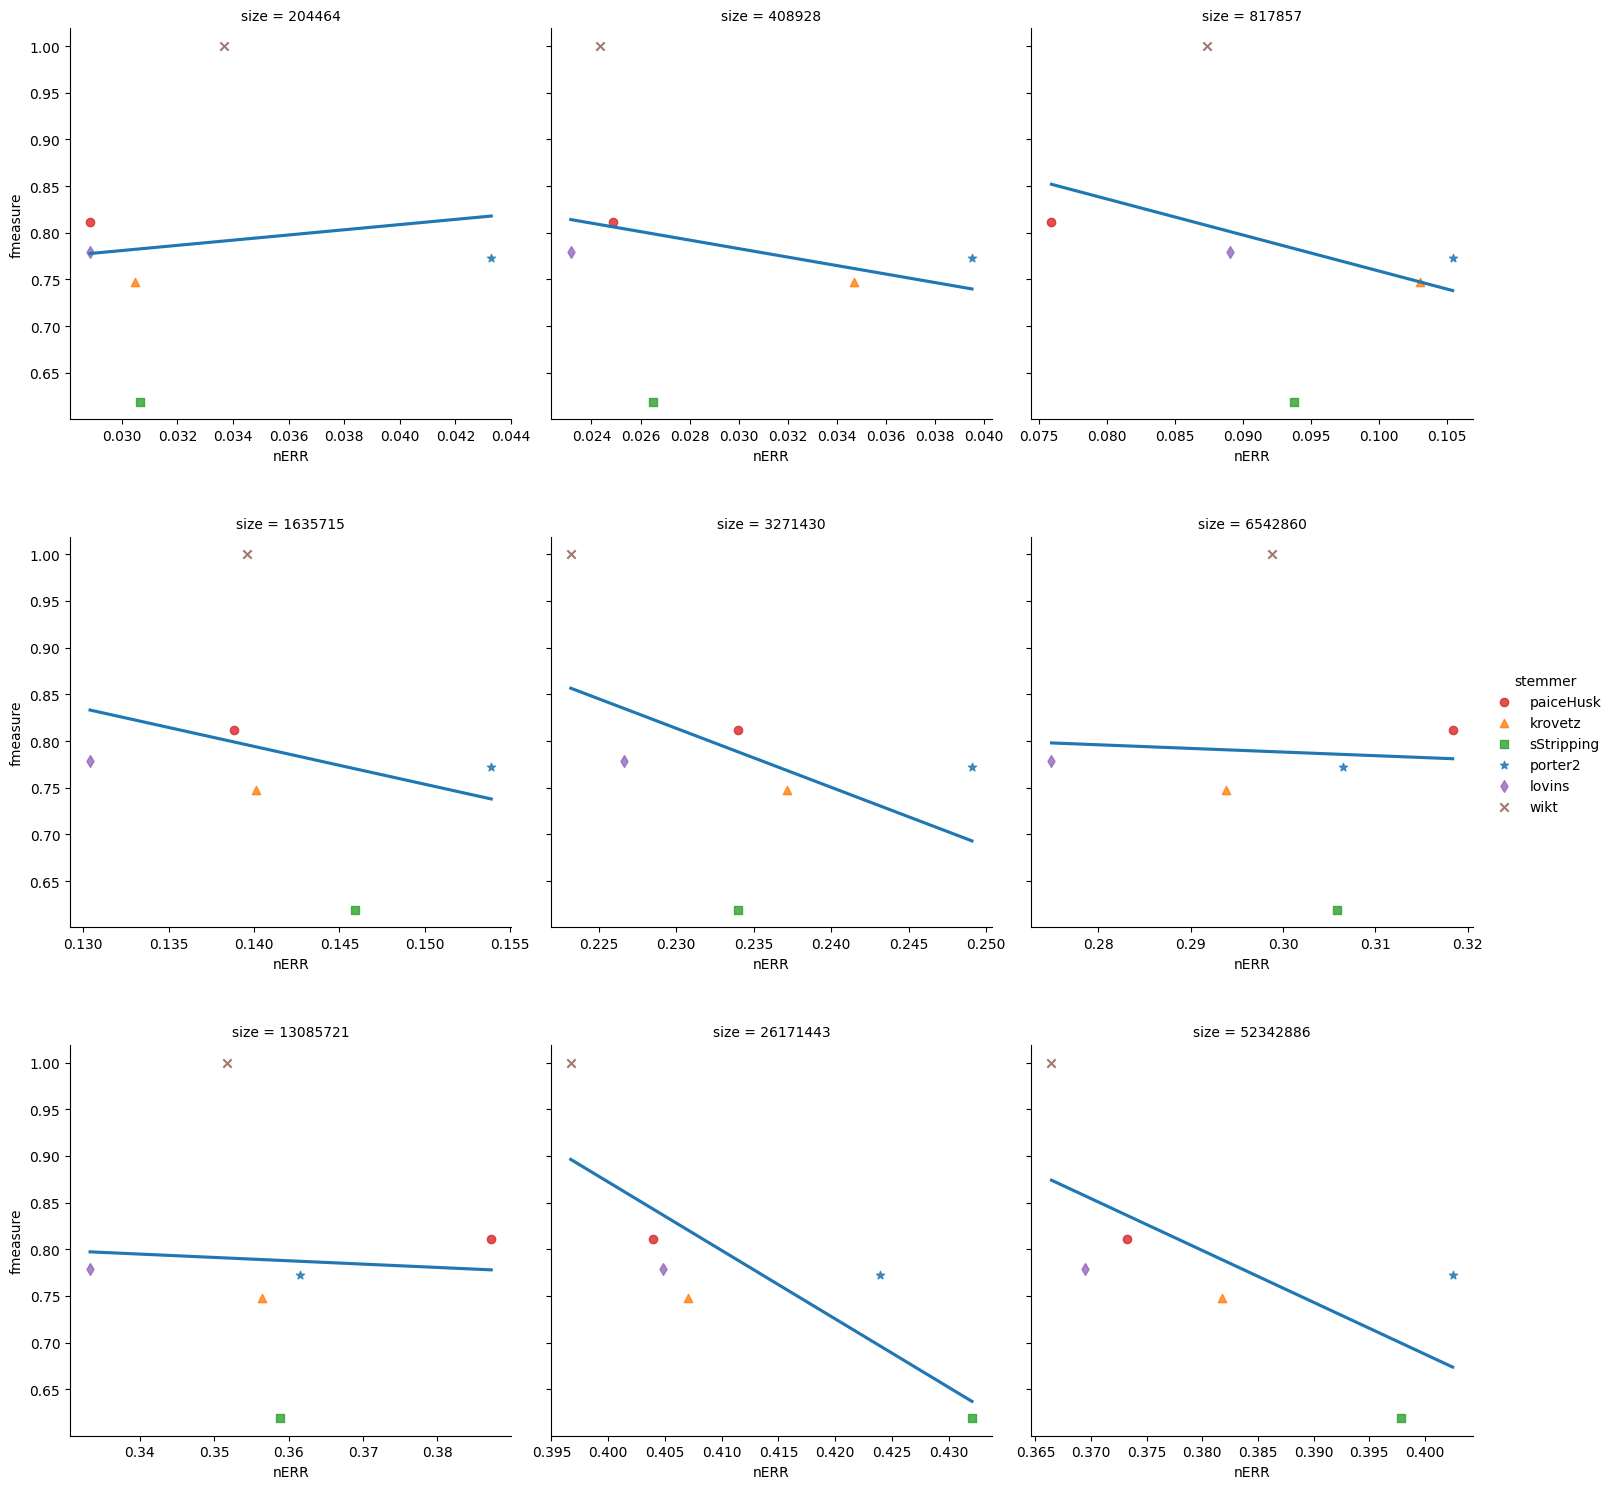

In [35]:
MARKERS = ["o","^","s","*","d","x"]
COLORS = ["tab:red","tab:orange","tab:green","tab:blue","tab:purple","tab:brown"]

graph = sns.lmplot(nERR_fmeasure, x="nERR", y="fmeasure", hue="stemmer", markers=MARKERS, palette=COLORS, col="size", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False)

for collection_size, ax in zip(np.unique(nERR_fmeasure["size"]), graph.axes):
    target_data = nERR_fmeasure[nERR_fmeasure["size"] == collection_size]
    sns.regplot(target_data, x="nERR", y="fmeasure", scatter=False, ci=None, ax=ax)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [14]:
for size in collection_sizes:
    x = nERR_fmeasure[nERR_fmeasure["size"] == size]["nERR"].to_numpy()
    y = nERR_fmeasure[nERR_fmeasure["size"] == size]["fmeasure"].to_numpy()
    print(f"Size: {size} {stats.pearsonr(x,y)}")

Size: 52342886 PearsonRResult(statistic=-0.6400683630809068, pvalue=0.1710114621422791)
Size: 26171443 PearsonRResult(statistic=-0.7781367310640197, pvalue=0.06837454291079269)
Size: 13085721 PearsonRResult(statistic=-0.0446565475853736, pvalue=0.933059705827244)
Size: 6542860 PearsonRResult(statistic=-0.031718164834412185, pvalue=0.9524387076510648)
Size: 3271430 PearsonRResult(statistic=-0.411345389062808, pvalue=0.41778277066971453)
Size: 1635715 PearsonRResult(statistic=-0.20862253242898593, pvalue=0.69160617825621)
Size: 817857 PearsonRResult(statistic=-0.3032796484235555, pvalue=0.5590281377821517)
Size: 408928 PearsonRResult(statistic=-0.1949042509593525, pvalue=0.7113456024562307)
Size: 204464 PearsonRResult(statistic=0.1865386326276101, pvalue=0.7234375118832023)


## nDCG

### Preparing data

In [3]:
#Initialise data dictionary with column names and empty lists
data = {"n" : [], "size" : [], "stemmer" : [], "QID" : [], "nDCG" : []}
data_avg = {"n" : [], "size" : [], "stemmer" : [], "nDCG" : []}
QID = np.arange(201,301)
for n, size in zip(collection_n_values, collection_sizes):
    #Gather the data from each length file
    values = list()
    values_avg = list()
    queryTotal = 0
    with open(path.join(data_dir_clueweb,f"collectionSize/nDCG-{n}"), "r") as f:
        for line in f:
            if line[0].isalpha(): 
                queryTotal = 0
                continue
            queryTotal+=1
            if queryTotal > 100:
                values_avg.append(float(line.strip()))
                continue
            values.append(float(line.strip()))
    i = 0
    for stemmer in labels:
        data["nDCG"].extend(values[100*i:100*(i+1)])
        data["size"].extend([size for _ in QID])
        data["n"].extend([n for _ in QID])
        data["stemmer"].extend([stemmer for _ in QID])
        data["QID"].extend(QID)
        i+=1
    data_avg["nDCG"].extend(values_avg)
    data_avg["size"].extend([size for _ in labels])
    data_avg["n"].extend([n for _ in labels])
    data_avg["stemmer"].extend(labels)
nDCG_size = pd.DataFrame(data)
nDCG_size_avg = pd.DataFrame(data_avg)

### Average nDCG

In [4]:
best_nDCG = list()
for size in collection_sizes:
    selected_data = nDCG_size_avg[nDCG_size_avg["size"] == size]
    best_nDCG.append(selected_data["nDCG"].max())

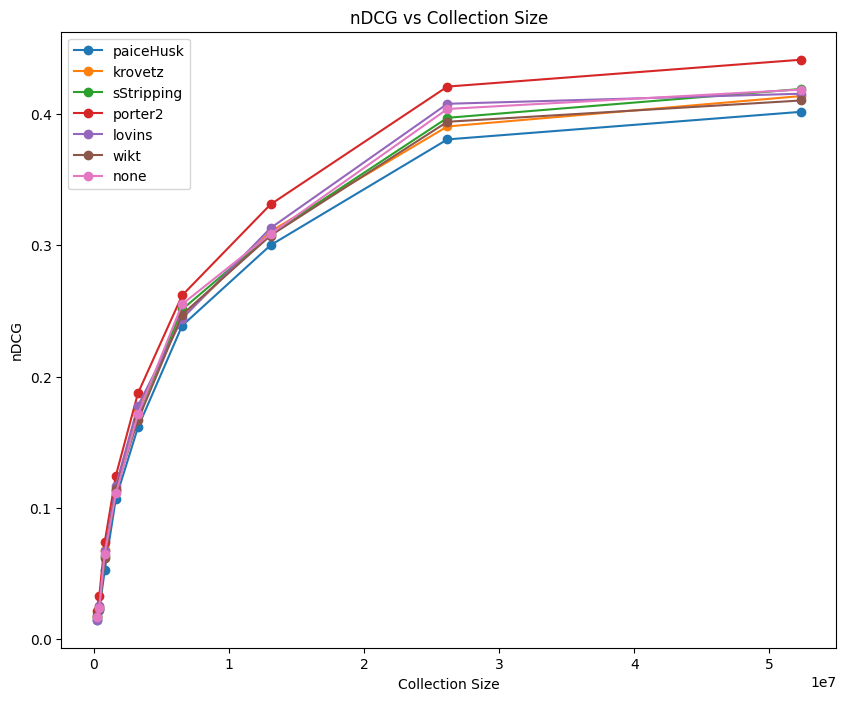

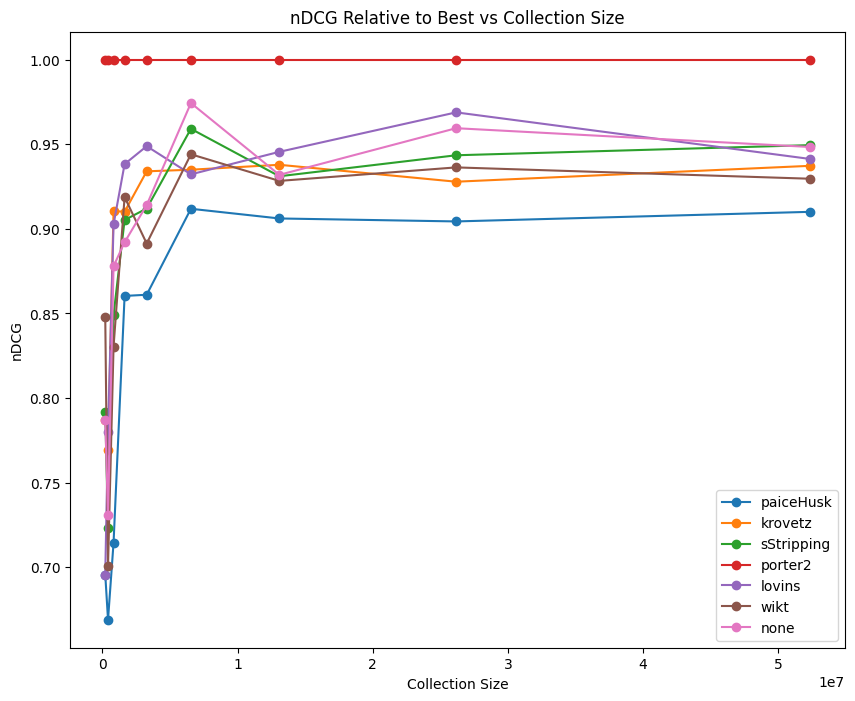

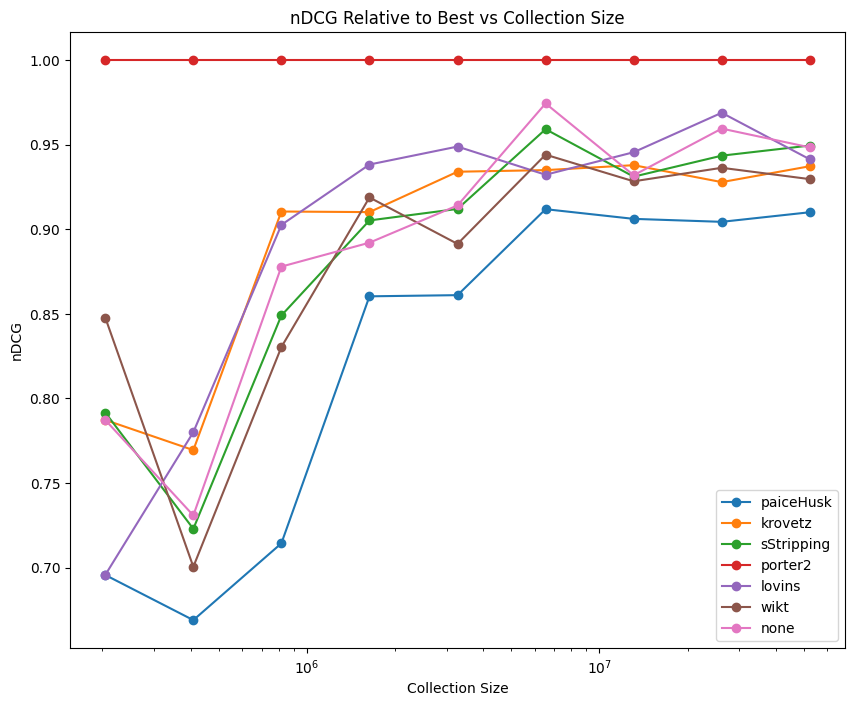

In [12]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nDCG_size_avg[nDCG_size_avg["stemmer"] == stemmer]
    plt.plot(stemmer_data["size"], stemmer_data["nDCG"], "o-", label=stemmer)

plt.title("nDCG vs Collection Size")
plt.xlabel("Collection Size")
plt.ylabel("nDCG")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nDCG_size_avg[nDCG_size_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nDCG"])/best_nDCG
    plt.plot(stemmer_data["size"], stemmer_values, "o-", label=stemmer)
    # plt.xscale("log")

plt.title("nDCG Relative to Best vs Collection Size")
plt.xlabel("Collection Size")
plt.ylabel("nDCG")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nDCG_size_avg[nDCG_size_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nDCG"])/best_nDCG
    plt.plot(stemmer_data["size"], stemmer_values, "o-", label=stemmer)
    plt.xscale("log")

plt.title("nDCG Relative to Best vs Collection Size")
plt.xlabel("Collection Size")
plt.ylabel("nDCG")
plt.legend()

### Statistical Significance

In [6]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
porter = list()
none = list()
for size in collection_sizes:
    p = list()
    n = list()
    target_data = nDCG_size[nDCG_size["size"] == size]
    p = target_data[target_data["stemmer"] == "porter2"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nDCG"].tolist()
    print(f"Size: {size} {stats.ttest_rel(p,n)}")
    porter.extend(p)
    none.extend(n)

Size: 52342886 TtestResult(statistic=1.219130348513699, pvalue=0.2256915399880386, df=99)
Size: 26171443 TtestResult(statistic=0.9376621113459527, pvalue=0.3506999858323645, df=99)
Size: 13085721 TtestResult(statistic=1.5207947605638177, pvalue=0.13149891905900055, df=99)
Size: 6542860 TtestResult(statistic=0.590607766946166, pvalue=0.5561291375762395, df=99)
Size: 3271430 TtestResult(statistic=1.6706921290330805, pvalue=0.09794109483146983, df=99)
Size: 1635715 TtestResult(statistic=1.3784599828891693, pvalue=0.17116843958222513, df=99)
Size: 817857 TtestResult(statistic=1.3453705190280683, pvalue=0.18157910732582025, df=99)
Size: 408928 TtestResult(statistic=1.7631121942158368, pvalue=0.08096718853909107, df=99)
Size: 204464 TtestResult(statistic=1.0000000000000002, pvalue=0.31974847413930163, df=99)


### Linguistic Accuracy

In [7]:
nDCG_fmeasure = nDCG_size_avg[nDCG_size_avg["stemmer"] != "none"]
nDCG_fmeasure = nDCG_fmeasure[nDCG_fmeasure["stemmer"] != "wikt"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
fmeasures = list()
for size in collection_sizes:
    fmeasures.extend(averages)
nDCG_fmeasure = nDCG_fmeasure.assign(fmeasure=fmeasures)

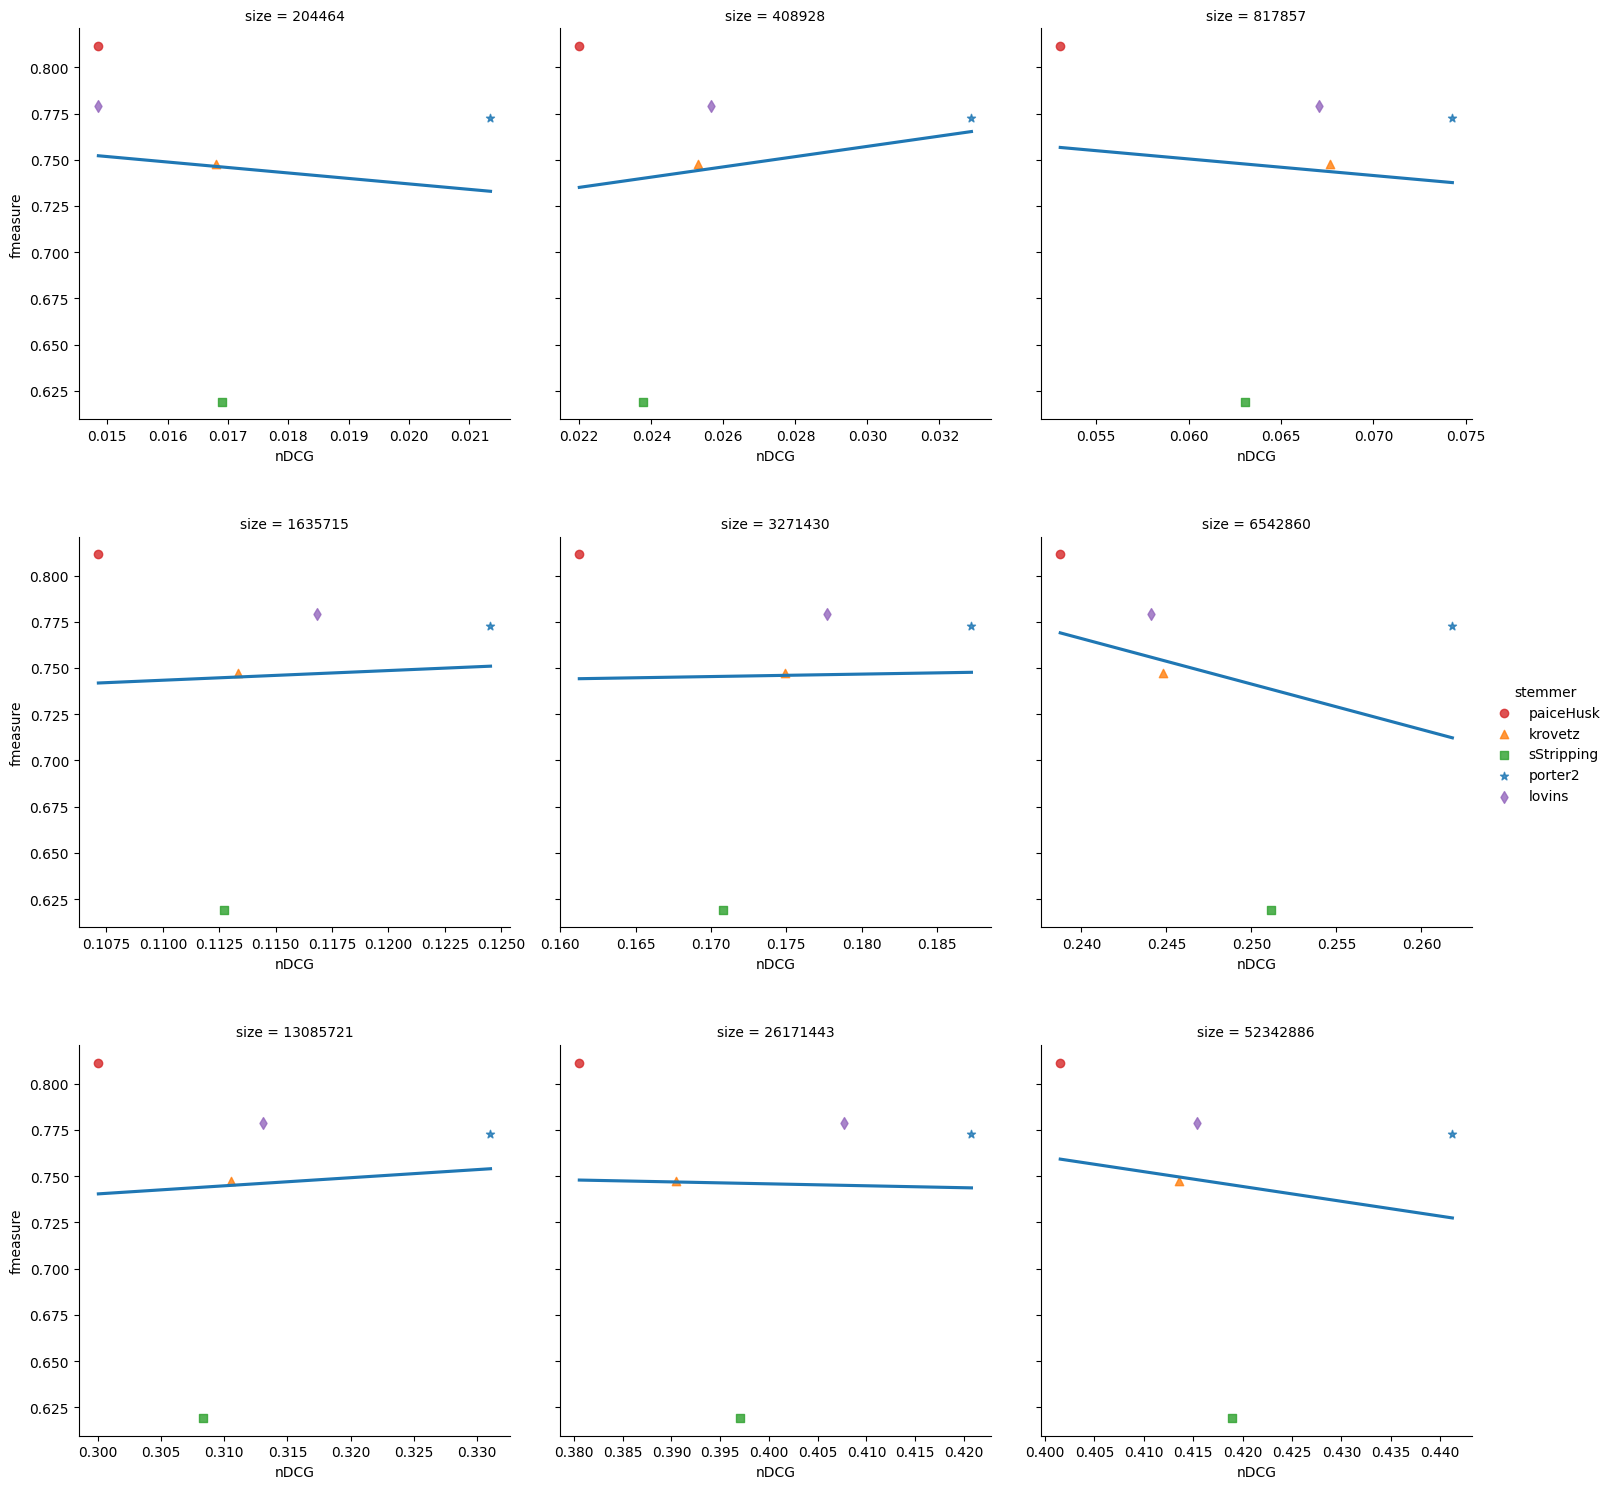

In [9]:
MARKERS = ["o","^","s","*","d"]
COLORS = ["tab:red","tab:orange","tab:green","tab:blue","tab:purple"]

graph = sns.lmplot(nDCG_fmeasure, x="nDCG", y="fmeasure", hue="stemmer", markers=MARKERS, palette=COLORS, col="size", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False)

for collection_size, ax in zip(np.unique(nDCG_fmeasure["size"]), graph.axes):
    target_data = nDCG_fmeasure[nDCG_fmeasure["size"] == collection_size]
    sns.regplot(target_data, x="nDCG", y="fmeasure", scatter=False, ci=None, ax=ax)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [10]:
for size in collection_sizes:
    x = nDCG_fmeasure[nDCG_fmeasure["size"] == size]["nDCG"].to_numpy()
    y = nDCG_fmeasure[nDCG_fmeasure["size"] == size]["fmeasure"].to_numpy()
    print(f"Size: {size} {stats.pearsonr(x,y)}")

Size: 52342886 PearsonRResult(statistic=-0.15594675331426303, pvalue=0.8022501882872822)
Size: 26171443 PearsonRResult(statistic=-0.021948359581885353, pvalue=0.9720567245018815)
Size: 13085721 PearsonRResult(statistic=0.06724553010696895, pvalue=0.9144449038389492)
Size: 6542860 PearsonRResult(statistic=-0.2919690182279189, pvalue=0.6336048263003483)
Size: 3271430 PearsonRResult(statistic=0.01699957490992031, pvalue=0.9783565115189695)
Size: 1635715 PearsonRResult(statistic=0.04500299117702796, pvalue=0.9427197590638923)
Size: 817857 PearsonRResult(statistic=-0.09392223108469669, pvalue=0.8805905529307414)
Size: 408928 PearsonRResult(statistic=0.15472631432575787, pvalue=0.8037852373899826)
Size: 204464 PearsonRResult(statistic=-0.10550129921560389, pvalue=0.8659211824894886)
